In [21]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

os.getcwd()

'C:\\Users\\Kenny\\Desktop\\AI\\aihw4'

# Data

In [22]:
# read training data - It is the aircraft engine run-to-failure data.
train = pd.read_csv(r'./train_usage.csv')
test = pd.read_csv(r'./test_usage.csv')

print('viwe the data shape', train.shape)
print('viwe the data shape', test.shape)

train.head()
#test_df.head()


viwe the data shape (19992, 47)
viwe the data shape (12739, 46)


,id,cycle,setting1,setting2,setting3,setting4,setting5,setting6,setting7,setting8,...,s25,s26,s27,s28,s29,s30,s31,s32,s33,RUL
0,1,1,0.533153,2.285803,0,0.591651,1.272152,5.420282,3.501178,-0.0007,...,392,2388,100,39.06,23.4190,17.417395,-5.424438,-11.046572,33.975011,191
1,1,2,0.533153,2.285803,0,0.591651,1.272152,5.420282,3.501178,0.0019,...,392,2388,100,39.00,23.4236,2.692229,6.492347,-1.090195,1.763264,190
2,1,3,0.533153,2.285803,0,0.591651,1.272152,5.420282,3.501178,-0.0043,...,390,2388,100,38.95,23.3442,17.608505,11.462310,-35.453907,3.903670,189
3,1,4,0.533153,2.285803,0,0.591651,1.272152,5.420282,3.501178,0.0007,...,392,2388,100,38.88,23.3739,2.885575,1.767567,1.996286,-3.450681,188
4,1,5,0.533153,2.285803,0,0.591651,1.272152,5.420282,3.501178,-0.0019,...,393,2388,100,38.90,23.4044,11.038508,8.525787,-0.011158,-1.185085,187


# 前處理

In [23]:
#檢查缺失值
print(train.isnull().values.any())

print(test.isnull().values.any())


False
False


In [24]:

#train = train.drop(['cycle'],axis=1)
#test = test.drop(['cycle'],axis=1)


In [25]:
#檢查每欄位資料獨特性，並印出僅包含一種值的欄位
def uniquechecker(dataset):
    unique_list = []
    for i in range(dataset.shape[1]):
        if len(pd.unique(dataset.iloc[:,i])) == 1:
            unique_list.append(dataset.columns[i])
                
    return unique_list
        

In [26]:
train_list = uniquechecker(train)
test_list = uniquechecker(test)
print(train_list)
print(test_list)


['setting1', 'setting2', 'setting3', 'setting4', 'setting5', 'setting6', 'setting7', 'setting10', 's4', 's8', 's18', 's24', 's26', 's27']
['setting1', 'setting2', 'setting3', 'setting4', 'setting5', 'setting6', 'setting7', 'setting10', 's4', 's8', 's18', 's24', 's26', 's27']


In [27]:
train = train.drop(['setting1', 'setting2', 'setting3', 'setting4', 'setting5', 'setting6', 'setting7', 'setting10', 's4', 's8', 's12', 's18', 's24', 's26', 's27'], axis=1)
test = test.drop(['setting1', 'setting2', 'setting3', 'setting4', 'setting5', 'setting6', 'setting7', 'setting10', 's4', 's8', 's12', 's18', 's24', 's26', 's27'], axis=1)


In [28]:
train.columns

Index(['id', 'cycle', 'setting8', 'setting9', 'time_usage', 's1', 's2', 's3',
       's5', 's6', 's7', 's9', 's10', 's11', 's13', 's14', 's15', 's16', 's17',
       's19', 's20', 's21', 's22', 's23', 's25', 's28', 's29', 's30', 's31',
       's32', 's33', 'RUL'],
      dtype='object')

In [29]:
numerical_column_list = ['setting8', 'setting9', 's1', 's2', 's3', 's5', 's6', 's7', 's9',
       's10', 's11', 's13', 's14', 's15', 's16', 's17', 's19', 's20',
       's21', 's22', 's23', 's25', 's28', 's29', 's30', 's31', 's32', 's33']


In [30]:
# os.chdir(r'C:\Users\Kenny\Desktop\aihw4\distributions')
# for i in range(len(numerical_column_list)):
#     plt.hist(train[numerical_column_list[i]], density=False, color = "lightblue", cumulative = False)
#     plt.title(numerical_column_list[i])
#     plt.xlabel('Value')
#     plt.ylabel('Frequency')
#     plt.savefig(fname=numerical_column_list[i] + '.png')
#     plt.show()

# os.chdir(r'C:\Users\Kenny\Desktop\aihw4')


In [31]:
zscore_column_list = ['s5', 's6', 's7', 's13', 's14', 's19', 's20', 's21', 's23', 's25', 's28', 's29', 'setting8']
#minmax_column_list = ['setting9', 's1', 's2', 's3', 's9', 's10', 's11', 's15', 's16', 's17', 's22', 's30', 's31', 's32', 's33']
minmax_column_list = ['setting9', 's1', 's2', 's3', 's9', 's10', 's11', 's15', 's16', 's17', 's22', 's30', 's31', 's32', 's33', 'time_usage']

# Partia#l Z-Score
scaler_num = StandardScaler().fit(train[zscore_column_list])
train[zscore_column_list] = scaler_num.transform(train[zscore_column_list])
test[zscore_column_list] = scaler_num.transform(test[zscore_column_list])

##Partial MinMax
scaler_cate = MinMaxScaler().fit(train[minmax_column_list])
train[minmax_column_list] = scaler_cate.transform(train[minmax_column_list])
test[minmax_column_list] = scaler_cate.transform(test[minmax_column_list])

##ALL MinMax
# scaler_all = MinMaxScaler().fit(train[numerical_column_list])
# train[numerical_column_list] = scaler_all.transform(train[numerical_column_list])
# test[numerical_column_list] = scaler_all.transform(test[numerical_column_list])

# ALl Z-Score
# scaler_all = StandardScaler().fit(train[numerical_column_list])
# train[numerical_column_list] = scaler_all.transform(train[numerical_column_list])
# test[numerical_column_list] = scaler_all.transform(test[numerical_column_list])


# LSTM

In [32]:
sequence_length = 31


In [33]:
# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
# pick the feature columns 
sensor_cols = ['s1', 's2', 's3', 's5', 's6',
       's7', 's9', 's10', 's11', 's13', 's14', 's15', 's16', 's17', 's19',
       's20', 's21', 's22', 's23', 's25', 's28', 's29', 's30', 's31', 's32', 's33']
sequence_cols = ['setting8', 'setting9']
# sequence_cols = ['setting8', 'setting9', 'time_usage']
sequence_cols.extend(sensor_cols)

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train[train['id']==id], sequence_length, sequence_cols)) 
           for id in train['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train[train['id']==id], sequence_length, ['RUL']) 
             for id in train['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape


(16985, 31, 28)


(16985, 1)

In [34]:
traincount_list = []
traincount_list.append(0) 
for i in range(label_array.shape[0]):
    if label_array[i][0] == 0:
        traincount_list.append(i)
        
#traincount_list   


In [35]:
for i in range(1,len(traincount_list)):  
    
    counter_all = int(traincount_list[i])
    counter_previous = int(traincount_list[i-1])
    counter = (int(traincount_list[i])-int(traincount_list[i-1]))
    spliter_val = round(counter*0.2)
    spliter_train = counter - spliter_val
    
    if i == 1:
#         seq_array_train = seq_array[0:spliter_train]
#         label_array_train = label_array[0:spliter_train]
                
#         seq_array_val = seq_array[spliter_train:counter+1]
#         label_array_val = label_array[spliter_train:counter+1]
        seq_array_train, seq_array_val, label_array_train, label_array_val = train_test_split(seq_array[0:counter_all+1], label_array[0:counter_all+1], test_size=0.4, random_state=42)
        
    else:
        #train 
#         temp_seq_train = seq_array[counter_previous:counter_previous+spliter_train]
#         temp_label_train = label_array[counter_previous:counter_previous+spliter_train]
        #val    
#         temp_seq_val = seq_array[counter_previous+spliter_train:counter_all]
#         temp_label_val = label_array[counter_previous+spliter_train:counter_all]
            
        seq_array_train_temp, seq_array_val_temp, label_array_train_temp, label_array_val_temp = train_test_split(seq_array[counter_previous:counter_all], label_array[counter_previous:counter_all], test_size=0.4, random_state=42)
    
        seq_array_train = np.concatenate([seq_array_train, seq_array_train_temp], axis=0)    
        label_array_train = np.concatenate([label_array_train, label_array_train_temp], axis=0)
        
        seq_array_val = np.concatenate([seq_array_val, seq_array_val_temp], axis=0)
        label_array_val = np.concatenate([label_array_val, label_array_val_temp], axis=0)
               
print(seq_array_train.shape)      
print(label_array_train.shape)
print(seq_array_val.shape)
print(label_array_val.shape)

print(seq_array_train.shape[0] + seq_array_val.shape[0])

(10153, 31, 28)
(10153, 1)
(6832, 31, 28)
(6832, 1)
16985


In [36]:
# #14826 for length=20
# #11544 for length=30
# print(label_array.shape[0])

# seq_array_val = seq_array[14000:]
# label_array_val = label_array[14000:]

# seq_array = seq_array[:14000]
# label_array = label_array[:14000]

# print(seq_array_val.shape[0] + seq_array.shape[0])


In [37]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(Bidirectional(LSTM(input_shape=(sequence_length, nb_features), units=128, return_sequences=True)))
# model.add(Dropout(0.2))

# model.add(LSTM(units=86, return_sequences=True))
# model.add(Dropout(0.2))

# model.add(LSTM(units=86, return_sequences=True))
# model.add(Dropout(0.2))

# model.add(Bidirectional(LSTM(units=86, return_sequences=True)))
# model.add(Dropout(0.2))

# model.add(Bidirectional(LSTM(units=86, return_sequences=True)))
# model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(units=86, return_sequences=True)))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(units=86, return_sequences=False)))
model.add(Dropout(0.2))

Adam = Adam(learning_rate=0.001)
#model.add(Dense(units=nb_out))
#model.add(Activation("linear"))
model.add(Dense(1))

model.compile(loss='mae', optimizer=Adam)

#print(model.summary())


In [38]:
# fit the network
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
#history = model.fit(seq_array, label_array, epochs=200, batch_size=256, shuffle=True, validation_split=0.2, verbose=2, callbacks=[es])

history = model.fit(seq_array_train, label_array_train, epochs=150, batch_size=512, shuffle=True, validation_data=(seq_array_val, label_array_val), verbose=2, callbacks=[es])

# list all data in history
# print(history.history.keys())


Epoch 1/150
20/20 - 11s - loss: 83.3809 - val_loss: 80.6534 - 11s/epoch - 573ms/step
Epoch 2/150
20/20 - 2s - loss: 74.0371 - val_loss: 76.2727 - 2s/epoch - 123ms/step
Epoch 3/150
20/20 - 3s - loss: 70.9467 - val_loss: 73.4457 - 3s/epoch - 127ms/step
Epoch 4/150
20/20 - 3s - loss: 68.4667 - val_loss: 70.9020 - 3s/epoch - 125ms/step
Epoch 5/150
20/20 - 3s - loss: 66.2338 - val_loss: 68.6588 - 3s/epoch - 127ms/step
Epoch 6/150
20/20 - 3s - loss: 64.2333 - val_loss: 66.6541 - 3s/epoch - 129ms/step
Epoch 7/150
20/20 - 2s - loss: 62.4247 - val_loss: 64.8706 - 2s/epoch - 125ms/step
Epoch 8/150
20/20 - 2s - loss: 60.7915 - val_loss: 63.2572 - 2s/epoch - 125ms/step
Epoch 9/150
20/20 - 3s - loss: 59.3822 - val_loss: 61.7733 - 3s/epoch - 125ms/step
Epoch 10/150
20/20 - 3s - loss: 58.1321 - val_loss: 60.3968 - 3s/epoch - 130ms/step
Epoch 11/150
20/20 - 2s - loss: 57.1092 - val_loss: 59.1839 - 2s/epoch - 124ms/step
Epoch 12/150
20/20 - 3s - loss: 56.1386 - val_loss: 58.0799 - 3s/epoch - 127ms/step

Epoch 99/150
20/20 - 3s - loss: 9.0910 - val_loss: 9.7283 - 3s/epoch - 135ms/step
Epoch 100/150
20/20 - 3s - loss: 9.3139 - val_loss: 9.7592 - 3s/epoch - 136ms/step
Epoch 101/150
20/20 - 3s - loss: 9.0070 - val_loss: 9.8468 - 3s/epoch - 140ms/step
Epoch 102/150
20/20 - 3s - loss: 9.0325 - val_loss: 9.0651 - 3s/epoch - 133ms/step
Epoch 103/150
20/20 - 3s - loss: 8.3147 - val_loss: 9.1264 - 3s/epoch - 131ms/step
Epoch 104/150
20/20 - 3s - loss: 8.3690 - val_loss: 8.7824 - 3s/epoch - 130ms/step
Epoch 105/150
20/20 - 3s - loss: 8.2036 - val_loss: 8.5113 - 3s/epoch - 131ms/step
Epoch 106/150
20/20 - 3s - loss: 8.1601 - val_loss: 8.9551 - 3s/epoch - 131ms/step
Epoch 107/150
20/20 - 3s - loss: 8.0080 - val_loss: 8.3992 - 3s/epoch - 131ms/step
Epoch 108/150
20/20 - 3s - loss: 7.9116 - val_loss: 8.5277 - 3s/epoch - 133ms/step
Epoch 109/150
20/20 - 3s - loss: 8.0529 - val_loss: 8.5840 - 3s/epoch - 137ms/step
Epoch 110/150
20/20 - 3s - loss: 8.0455 - val_loss: 8.7985 - 3s/epoch - 138ms/step
Epoch

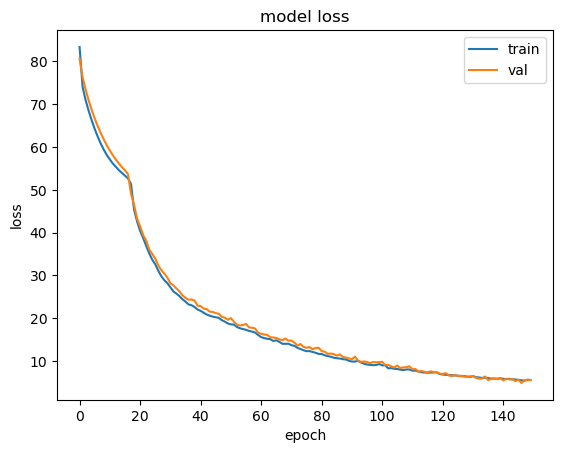

In [39]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()


In [40]:
#We pick the last sequence for each id in the test data
# seq_array_test_last = [test[test['id']==id][sequence_cols].values[-sequence_length:] 
#                        for id in test['id'].unique() if len(test[test['id']==id]) >= sequence_length]

# seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# y_pred_test = model.predict(seq_array_test_last)

# test_set = pd.DataFrame(y_pred_test, columns=['RUL'])
# test_set.index = test_set.index+1
# test_set.to_csv('my_submission.csv', index_label='id')


In [41]:
seq_array_test_last = [test[test['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test['id'].unique() if len(test[test['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

y_pred_test = model.predict(seq_array_test_last)

data_numerical={  "id":[], 
        "RUL":[]}

for i in range(97):
    data_numerical['id'].append(i+1)
    data_numerical['RUL'].append(float(y_pred_test[i][y_pred_test.shape[1]-1]))


df = pd.DataFrame(data_numerical)
df.to_csv('my_submission.csv', index=False)


4/4 [==============================] - 2s 10ms/step
